 Starting Machine Learning Analysis of BT and O3 Concentration Relationship
=== Data Loading and Preprocessing (BT vs O3 Analysis) ===
Data shape: (366, 40)
Date range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
BT ridership range: 480178 - 1037403
O3 concentration range: 10.690 - 105.590

=== BT-O3 Feature Preparation ===
Available features count: 23
Main features: ['BT', 'BT_lag1', 'BT_lag2', 'BT_lag3', 'BT_lag7', 'BT_ma3', 'BT_ma7', 'BT_ma14', 'BT_std7', 'BT_min7']
Modeling data shape: (353, 24)
BT-O3 correlation: 0.221

=== BT-O3 Model Training ===
Training set: 282 samples
Test set: 71 samples
Training period BT-O3 correlation: 0.260
Test period BT-O3 correlation: 0.013

 Training Linear Regression...
 Complete - CV RMSE: 561.3233
   Test R²: 0.0638, Correlation: 0.3151

 Training Ridge Regression...
 Complete - CV RMSE: 228.4805
   Test R²: 0.0903, Correlation: 0.3204

 Training Lasso Regression...
 Complete - CV RMSE: 220.8086
   Test R²: 0.1337, Correlation: 0.3675

 Training R

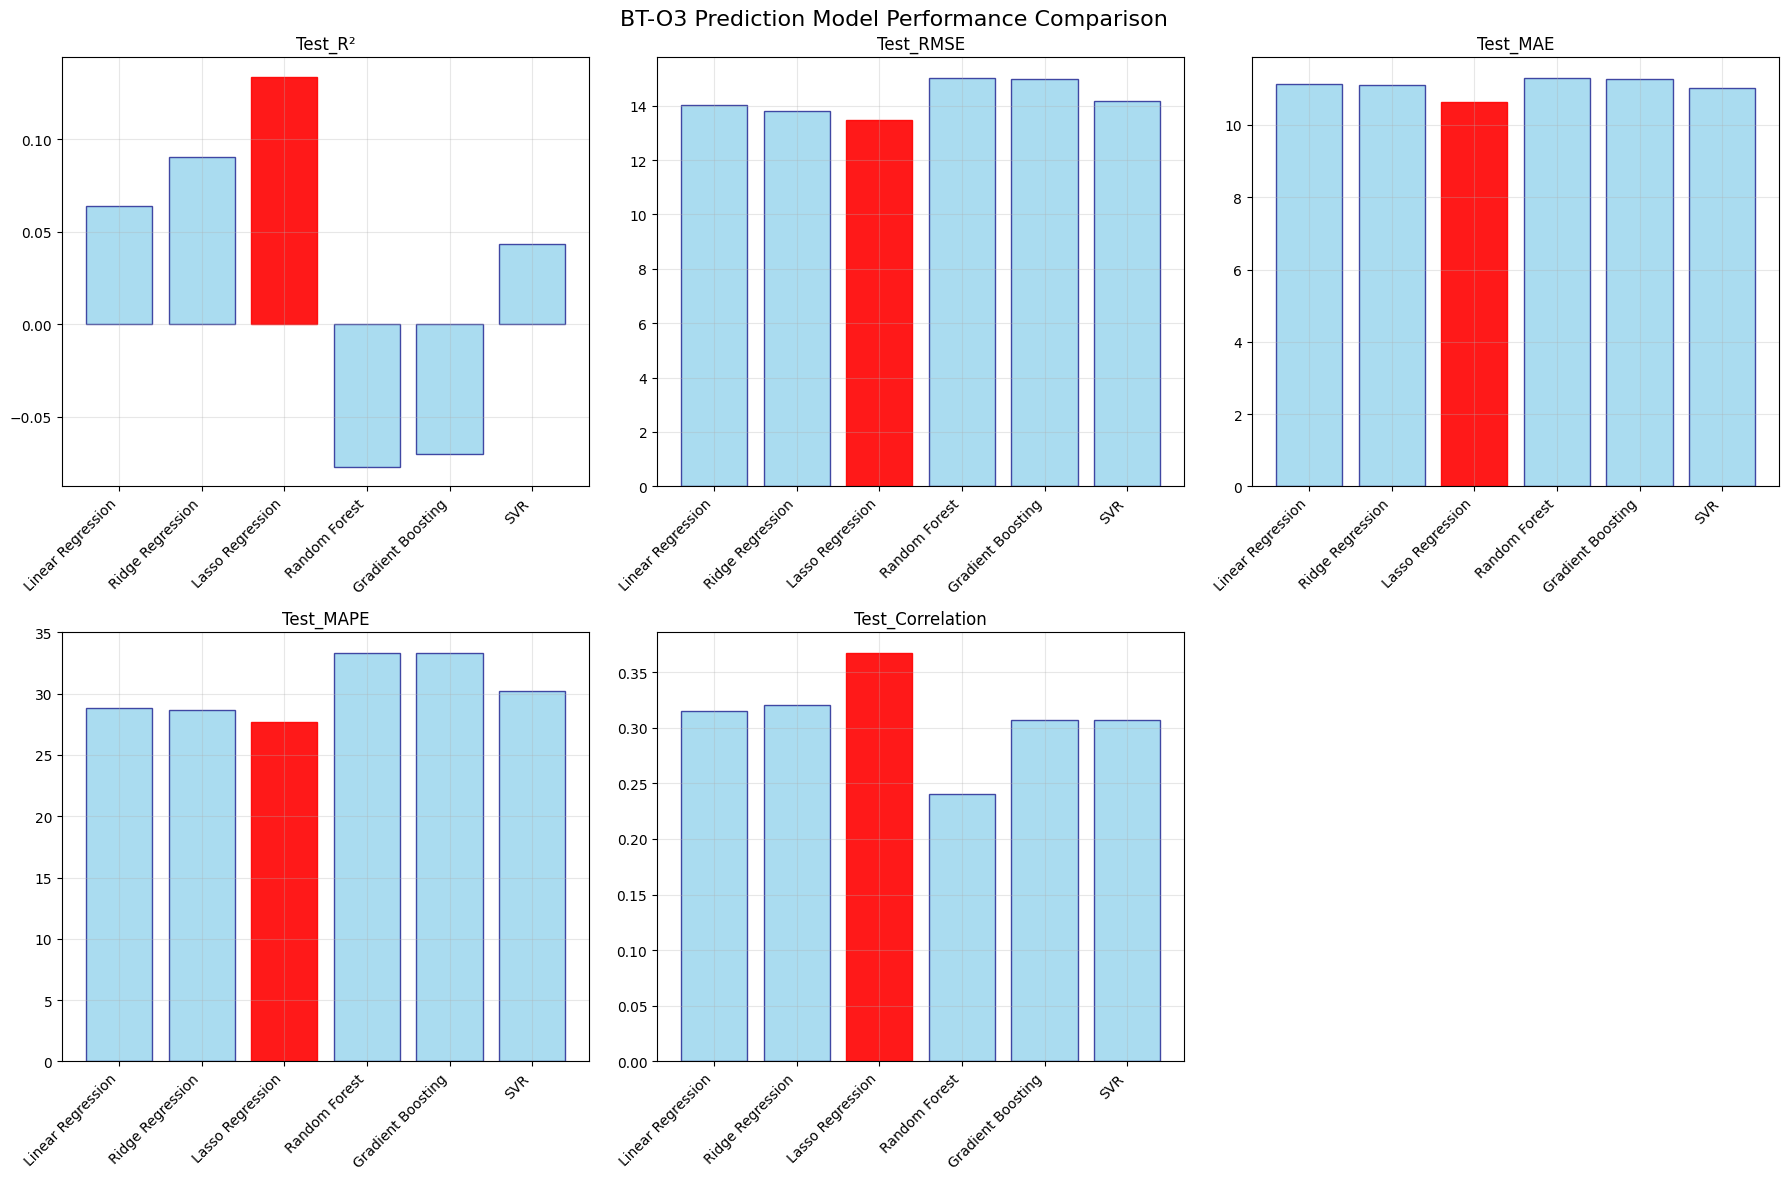

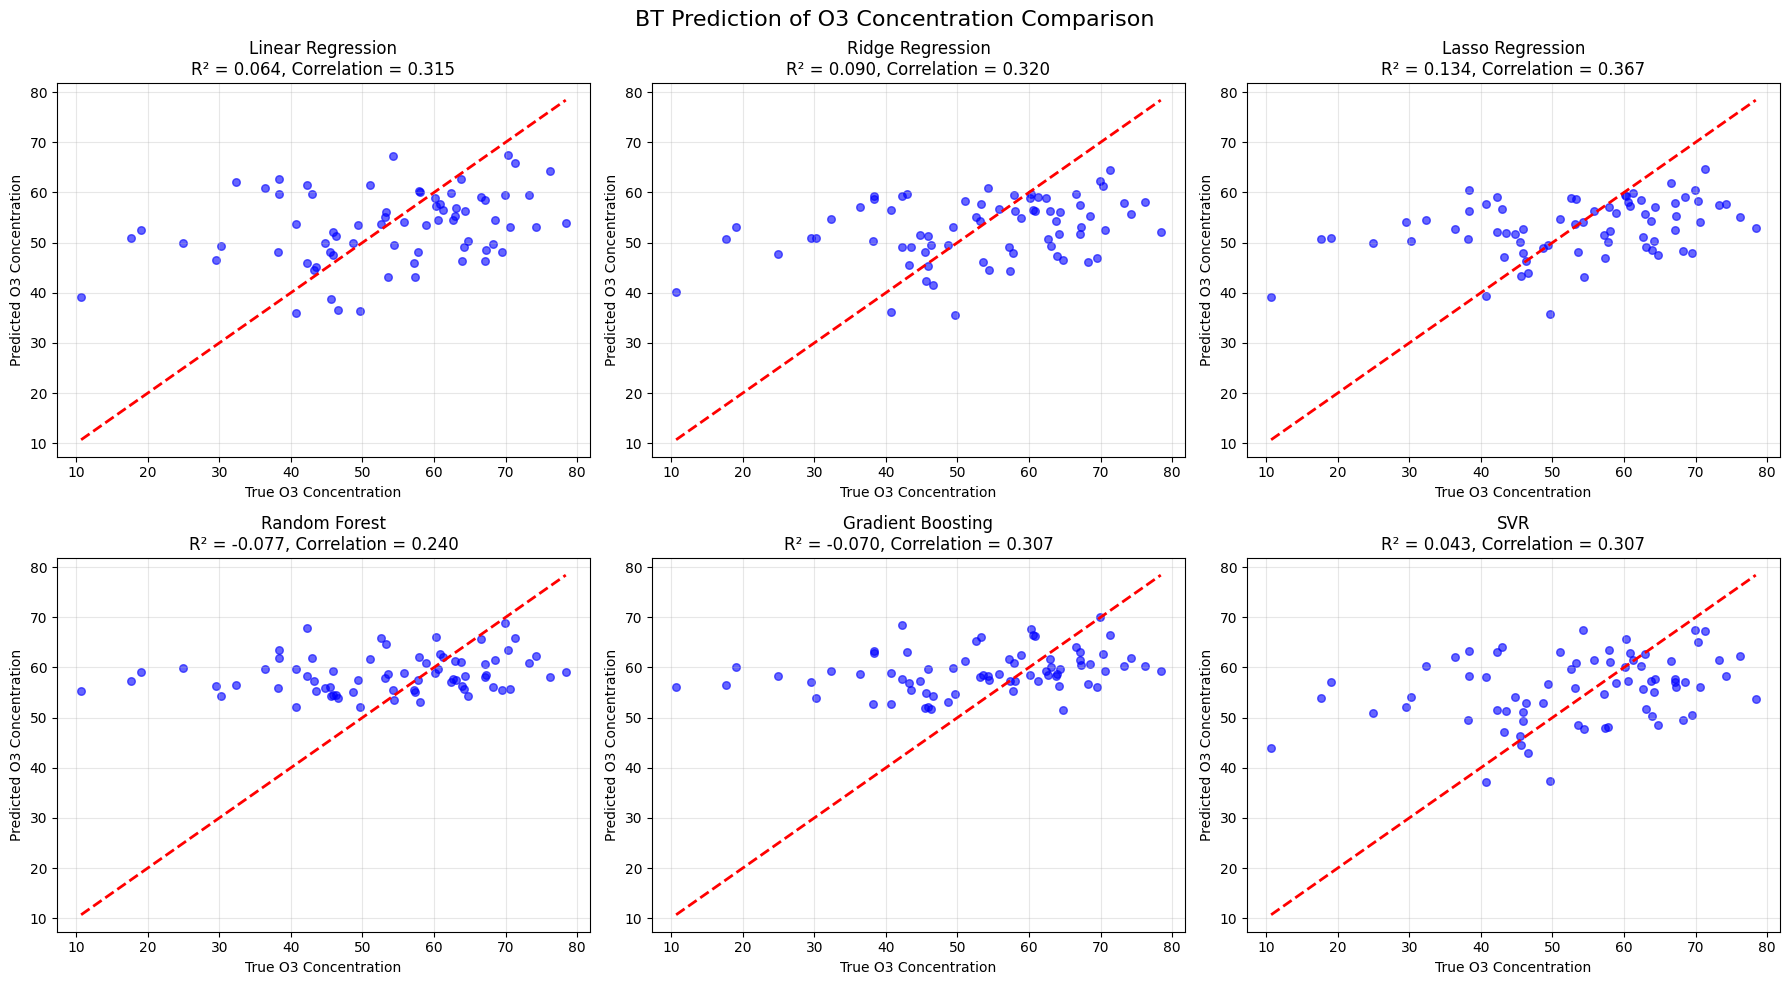


🌟 Random Forest Feature Importance:
BT-related features:
                 feature  importance
7                BT_ma14    0.120990
22  BT_month_interaction    0.069100
10               BT_max7    0.058382
8                BT_std7    0.038310
4                BT_lag7    0.036376
Time features:
                   feature  importance
15               cos_month    0.048370
16                 sin_day    0.013588
21  BT_weekend_interaction    0.010290
13               DayOfWeek    0.006807
14               sin_month    0.003697
O3 historical features:
    feature  importance
18  O3_lag1    0.382281
20  O3_lag3    0.025247
19  O3_lag2    0.024950

🌟 Gradient Boosting Feature Importance:
BT-related features:
                 feature  importance
7                BT_ma14    0.098600
10               BT_max7    0.075635
22  BT_month_interaction    0.059120
8                BT_std7    0.056849
1                BT_lag1    0.053370
Time features:
                   feature  importance
15           

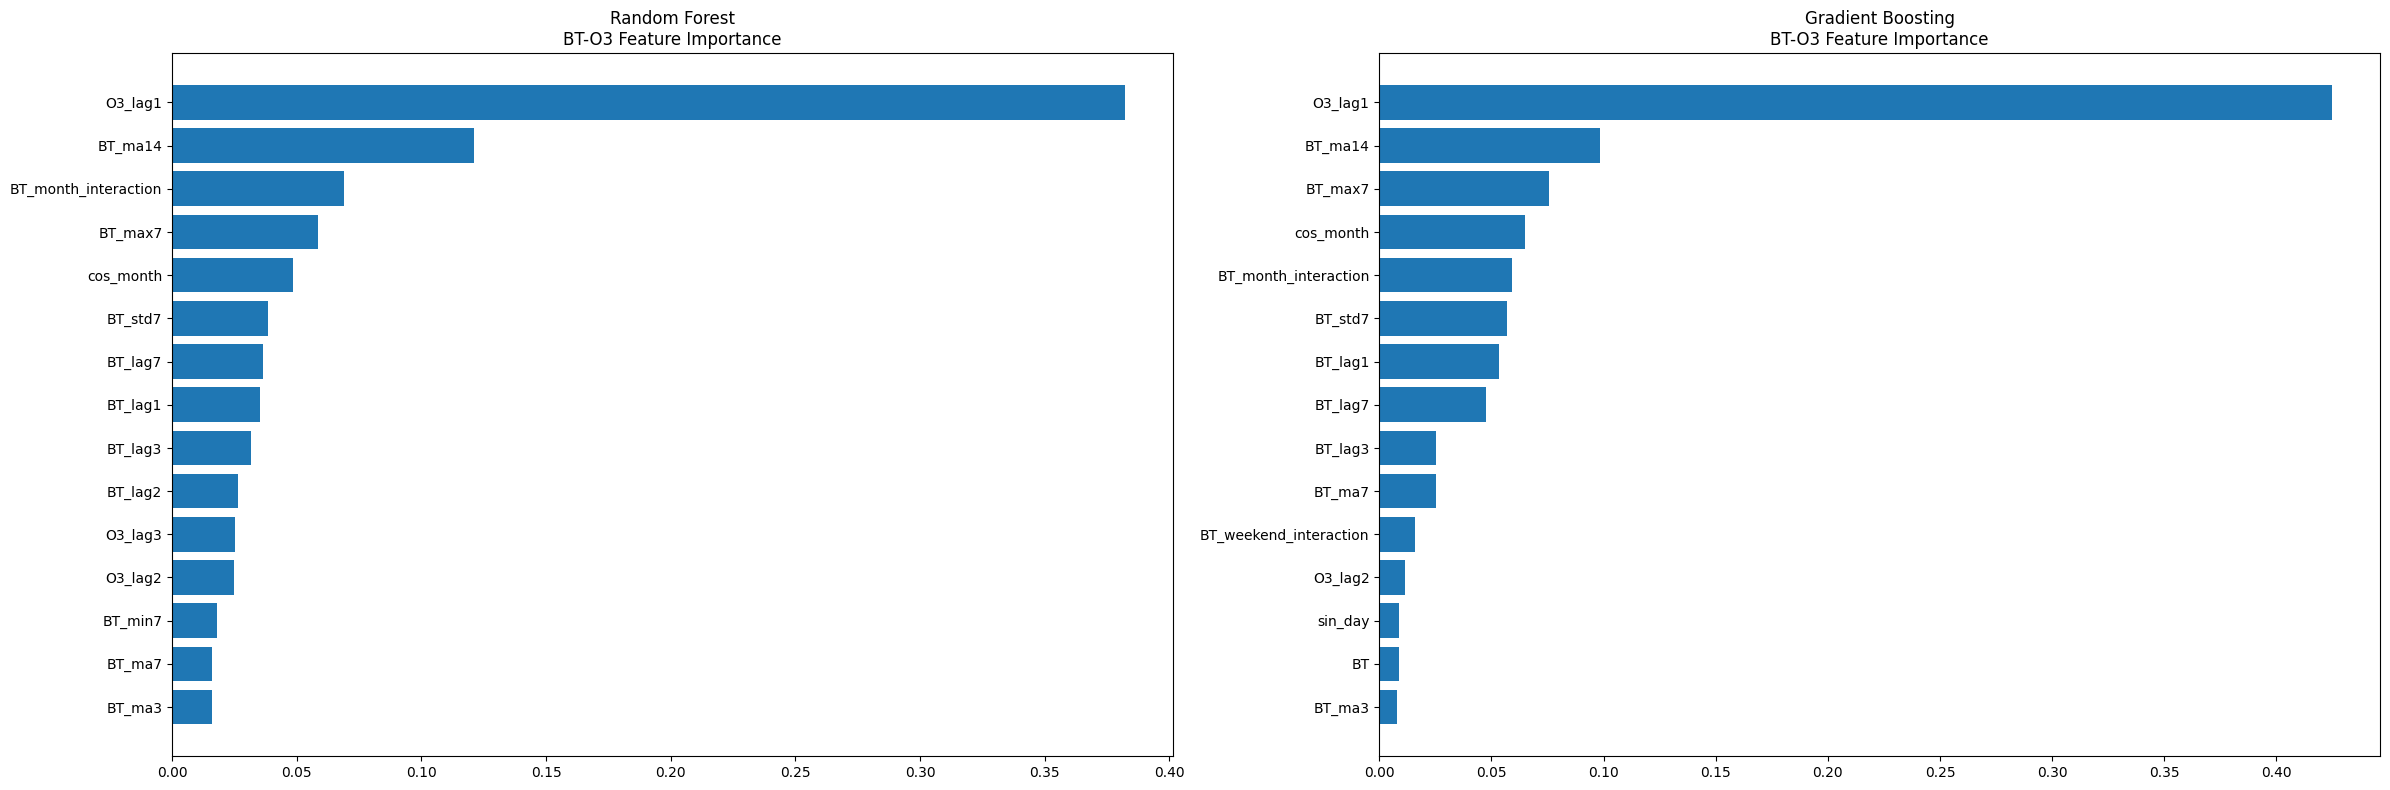

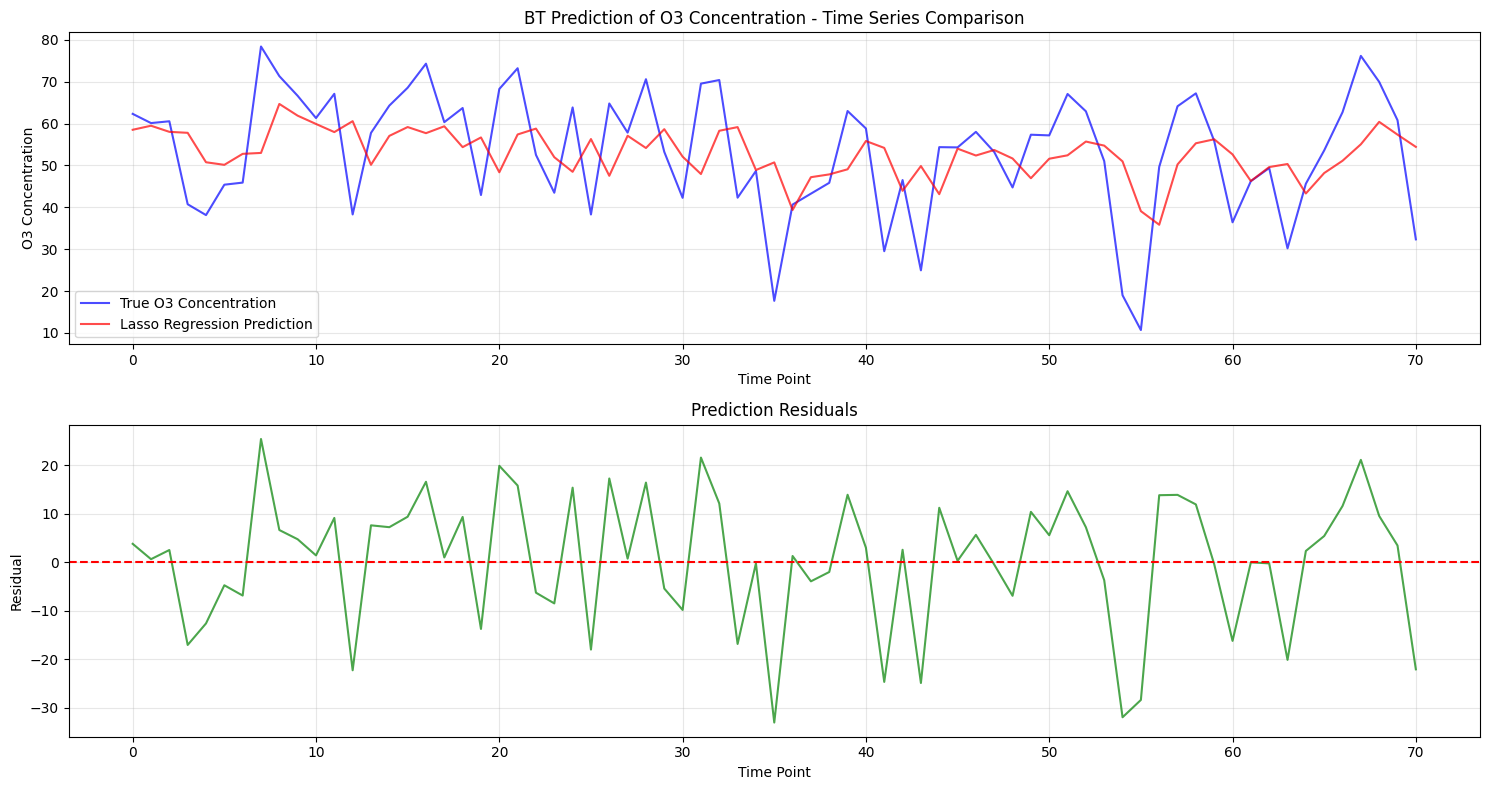


 BT-O3 Relationship Modeling Summary
 Best Model: Lasso Regression
 Best R² Score: 0.1337
 Prediction Correlation: 0.3675
 Original BT-O3 Correlation: 0.2209

 Conclusion:
   BT ridership has moderate predictive power for O3 concentration


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# Part 1: Data Loading and Preprocessing
# ============================================================================

def load_and_prepare_data():
    """
    Independent data loading and preprocessing function - Focus on BT and O3 relationship
    """
    print("=== Data Loading and Preprocessing (BT vs O3 Analysis) ===")
    
    # 1. Read data
    traffic_df = pd.read_csv('MTA_Ridership_wide_format.csv')
    air_df = pd.read_csv('nyc_2024_air.csv')
    
    # 2. Data preprocessing
    traffic_df['Date'] = pd.to_datetime(traffic_df['Date'])
    air_df['DATE'] = pd.to_datetime(air_df['DATE'])
    
    # 3. Merge data
    merged_df = pd.merge(traffic_df, air_df, left_on='Date', right_on='DATE')
    
    # 4. Create time features
    merged_df['is_weekend'] = merged_df['Date'].dt.weekday >= 5
    merged_df['Month'] = merged_df['Date'].dt.month
    merged_df['DayOfWeek'] = merged_df['Date'].dt.dayofweek
    
    # 5. Create BT lag features
    for lag in [1, 2, 3, 7]:  # Including weekly lag
        merged_df[f'BT_lag{lag}'] = merged_df['BT'].shift(lag)
    
    # 6. Create BT moving average features
    merged_df['BT_ma3'] = merged_df['BT'].rolling(window=3, center=True).mean()
    merged_df['BT_ma7'] = merged_df['BT'].rolling(window=7, center=True).mean()
    merged_df['BT_ma14'] = merged_df['BT'].rolling(window=14, center=True).mean()
    
    # 7. Create O3 lag features (for prediction)
    for lag in [1, 2, 3]:
        merged_df[f'O3_lag{lag}'] = merged_df['O3(mg/kg)'].shift(lag)
    
    # 8. Create seasonal features
    merged_df['sin_month'] = np.sin(2 * np.pi * merged_df['Month'] / 12)
    merged_df['cos_month'] = np.cos(2 * np.pi * merged_df['Month'] / 12)
    merged_df['sin_day'] = np.sin(2 * np.pi * merged_df['DayOfWeek'] / 7)
    merged_df['cos_day'] = np.cos(2 * np.pi * merged_df['DayOfWeek'] / 7)
    
    # 9. Create BT statistical features
    merged_df['BT_std7'] = merged_df['BT'].rolling(window=7).std()
    merged_df['BT_min7'] = merged_df['BT'].rolling(window=7).min()
    merged_df['BT_max7'] = merged_df['BT'].rolling(window=7).max()
    
    # 10. Create interaction features
    merged_df['BT_weekend_interaction'] = merged_df['BT'] * merged_df['is_weekend']
    merged_df['BT_month_interaction'] = merged_df['BT'] * merged_df['Month']
    
    print(f"Data shape: {merged_df.shape}")
    print(f"Date range: {merged_df['Date'].min()} to {merged_df['Date'].max()}")
    print(f"BT ridership range: {merged_df['BT'].min():.0f} - {merged_df['BT'].max():.0f}")
    print(f"O3 concentration range: {merged_df['O3(mg/kg)'].min():.3f} - {merged_df['O3(mg/kg)'].max():.3f}")
    
    return merged_df

# ============================================================================
# Part 2: Feature Selection and Data Preparation
# ============================================================================

def prepare_bt_o3_features(df):
    """
    Prepare BT and O3 related features
    """
    print(f"\n=== BT-O3 Feature Preparation ===")
    
    # Define feature set - Focus on BT and time-related features
    feature_columns = [
        # BT core features
        'BT',
        
        # BT lag features
        'BT_lag1', 'BT_lag2', 'BT_lag3', 'BT_lag7',
        
        # BT moving average features
        'BT_ma3', 'BT_ma7', 'BT_ma14',
        
        # BT statistical features
        'BT_std7', 'BT_min7', 'BT_max7',
        
        # Time features (control variables)
        'is_weekend', 'Month', 'DayOfWeek',
        
        # Seasonal features
        'sin_month', 'cos_month', 'sin_day', 'cos_day',
        
        # O3 historical features (for prediction)
        'O3_lag1', 'O3_lag2', 'O3_lag3',
        
        # Interaction features
        'BT_weekend_interaction', 'BT_month_interaction'
    ]
    
    target = 'O3(mg/kg)'
    
    # Check feature availability
    available_features = [col for col in feature_columns if col in df.columns]
    missing_features = [col for col in feature_columns if col not in df.columns]
    
    if missing_features:
        print(f"Warning: Missing features: {missing_features}")
    
    print(f"Available features count: {len(available_features)}")
    print(f"Main features: {[f for f in available_features if 'BT' in f][:10]}")
    
    # Prepare modeling data
    model_data = df[available_features + [target]].dropna()
    
    X = model_data[available_features]
    y = model_data[target]
    
    # Basic statistics
    print(f"Modeling data shape: {model_data.shape}")
    print(f"BT-O3 correlation: {model_data['BT'].corr(model_data[target]):.3f}")
    
    return X, y, available_features

# ============================================================================
# Part 3: BT-O3 Model Configuration
# ============================================================================

def create_bt_o3_models():
    """
    Customized model configuration for BT-O3 relationship
    """
    models_config = {
        'Linear Regression': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())
            ]),
            'params': {}
        },
        
        'Ridge Regression': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', Ridge(random_state=42))
            ]),
            'params': {
                'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
            }
        },
        
        'Lasso Regression': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', Lasso(random_state=42, max_iter=3000))
            ]),
            'params': {
                'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
            }
        },
        
        'Random Forest': {
            'pipeline': Pipeline([
                ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
            ]),
            'params': {
                'regressor__n_estimators': [50, 100, 200, 300],
                'regressor__max_depth': [5, 10, 15, None],
                'regressor__min_samples_split': [2, 5, 10],
                'regressor__min_samples_leaf': [1, 2, 4]
            }
        },
        
        'Gradient Boosting': {
            'pipeline': Pipeline([
                ('regressor', GradientBoostingRegressor(random_state=42))
            ]),
            'params': {
                'regressor__n_estimators': [50, 100, 200],
                'regressor__learning_rate': [0.01, 0.05, 0.1, 0.15],
                'regressor__max_depth': [3, 5, 7, 9],
                'regressor__subsample': [0.8, 0.9, 1.0]
            }
        },
        
        'SVR': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', SVR())
            ]),
            'params': {
                'regressor__C': [0.01, 0.1, 1, 10, 100],
                'regressor__kernel': ['rbf', 'linear', 'poly'],
                'regressor__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                'regressor__epsilon': [0.01, 0.1, 0.2]
            }
        }
    }
    
    return models_config

def calculate_metrics(y_true, y_pred):
    """
    Calculate evaluation metrics
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate MAPE, avoid division by zero
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.inf
    
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape,
        'Correlation': correlation
    }

# ============================================================================
# Part 4: BT-O3 Model Training
# ============================================================================

def train_bt_o3_models(X, y, models_config, test_size=0.2, cv_folds=5):
    """
    Train BT-O3 prediction models
    """
    print(f"\n=== BT-O3 Model Training ===")
    
    # Time series split
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Training period BT-O3 correlation: {X_train.iloc[:,0].corr(y_train):.3f}")
    print(f"Test period BT-O3 correlation: {X_test.iloc[:,0].corr(y_test):.3f}")
    
    # Time series cross validation
    tscv = TimeSeriesSplit(n_splits=cv_folds)
    
    results = []
    best_models = {}
    predictions = {}
    
    for model_name, config in models_config.items():
        print(f"\n Training {model_name}...")
        
        try:
            # GridSearchCV
            grid_search = GridSearchCV(
                estimator=config['pipeline'],
                param_grid=config['params'],
                cv=tscv,
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            
            # Training
            grid_search.fit(X_train, y_train)
            
            # Prediction
            y_pred_train = grid_search.predict(X_train)
            y_pred_test = grid_search.predict(X_test)
            
            # Calculate metrics
            train_metrics = calculate_metrics(y_train, y_pred_train)
            test_metrics = calculate_metrics(y_test, y_pred_test)
            
            # Store results
            result = {
                'Model': model_name,
                'Best_Params': grid_search.best_params_,
                'CV_Score': -grid_search.best_score_,
                'Train_R²': train_metrics['R²'],
                'Test_R²': test_metrics['R²'],
                'Train_RMSE': train_metrics['RMSE'],
                'Test_RMSE': test_metrics['RMSE'],
                'Test_MAE': test_metrics['MAE'],
                'Test_MAPE': test_metrics['MAPE'],
                'Test_Correlation': test_metrics['Correlation']
            }
            
            results.append(result)
            best_models[model_name] = grid_search.best_estimator_
            predictions[model_name] = y_pred_test
            
            print(f" Complete - CV RMSE: {-grid_search.best_score_:.4f}")
            print(f"   Test R²: {test_metrics['R²']:.4f}, Correlation: {test_metrics['Correlation']:.4f}")
            
        except Exception as e:
            print(f" Failed - {str(e)}")
            continue
    
    return results, best_models, predictions, y_test, X_test

# ============================================================================
# Part 5: BT-O3 Results Analysis
# ============================================================================

def analyze_bt_o3_results(results, predictions, y_test, X_test, feature_names, best_models):
    """
    Analyze modeling results of BT-O3 relationship
    """
    print(f"\n=== BT-O3 Analysis Results ===")
    
    results_df = pd.DataFrame(results)
    
    # 1. Model performance table
    print("\n Model Performance Comparison:")
    display_cols = ['Model', 'CV_Score', 'Test_R²', 'Test_RMSE', 'Test_MAE', 'Test_Correlation']
    print(results_df[display_cols].round(4))
    
    # 2. Performance visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('BT-O3 Prediction Model Performance Comparison', fontsize=16)
    
    metrics = ['Test_R²', 'Test_RMSE', 'Test_MAE', 'Test_MAPE', 'Test_Correlation']
    positions = [(0,0), (0,1), (0,2), (1,0), (1,1)]
    
    for i, metric in enumerate(metrics):
        row, col = positions[i]
        bars = axes[row, col].bar(results_df['Model'], results_df[metric], 
                                  color='skyblue', edgecolor='navy', alpha=0.7)
        axes[row, col].set_title(f'{metric}')
        axes[row, col].set_xticklabels(results_df['Model'], rotation=45, ha='right')
        axes[row, col].grid(True, alpha=0.3)
        
        # Highlight best model
        if metric in ['Test_R²', 'Test_Correlation']:
            best_idx = results_df[metric].idxmax()
        else:
            best_idx = results_df[metric].idxmin()
        bars[best_idx].set_color('red')
        bars[best_idx].set_alpha(0.9)
    
    axes[1, 2].axis('off')
    plt.tight_layout()
    plt.show()
    
    # 3. Prediction effect visualization
    n_models = len(predictions)
    cols = min(3, n_models)
    rows = (n_models + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    fig.suptitle('BT Prediction of O3 Concentration Comparison', fontsize=16)
    
    if n_models == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, (model_name, y_pred) in enumerate(predictions.items()):
        row, col = i // cols, i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        ax.scatter(y_test, y_pred, alpha=0.6, color='blue', s=30)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        ax.set_xlabel('True O3 Concentration')
        ax.set_ylabel('Predicted O3 Concentration')
        
        r2 = r2_score(y_test, y_pred)
        corr = np.corrcoef(y_test, y_pred)[0, 1]
        ax.set_title(f'{model_name}\nR² = {r2:.3f}, Correlation = {corr:.3f}')
        ax.grid(True, alpha=0.3)
    
    # Hide extra subplots
    for i in range(n_models, rows * cols):
        row, col = i // cols, i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 4. Feature importance analysis
    tree_models = ['Random Forest', 'Gradient Boosting']
    available_tree_models = [m for m in tree_models if m in best_models]
    
    if available_tree_models:
        fig, axes = plt.subplots(1, len(available_tree_models), figsize=(12*len(available_tree_models), 8))
        
        if len(available_tree_models) == 1:
            axes = [axes]
        
        for i, model_name in enumerate(available_tree_models):
            model = best_models[model_name]
            
            if hasattr(model.named_steps['regressor'], 'feature_importances_'):
                importance = model.named_steps['regressor'].feature_importances_
                
                importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importance
                }).sort_values('importance', ascending=False)
                
                # Categorize by feature type
                bt_features = importance_df[importance_df['feature'].str.contains('BT')]
                time_features = importance_df[importance_df['feature'].str.contains('weekend|Month|Day|sin|cos')]
                o3_features = importance_df[importance_df['feature'].str.contains('O3')]
                
                print(f"\n🌟 {model_name} Feature Importance:")
                print("BT-related features:")
                print(bt_features.head())
                print("Time features:")
                print(time_features.head())
                print("O3 historical features:")
                print(o3_features.head())
                
                # Visualization
                top_features = importance_df.head(15)
                axes[i].barh(top_features['feature'], top_features['importance'])
                axes[i].set_title(f'{model_name}\nBT-O3 Feature Importance')
                axes[i].invert_yaxis()
        
        plt.tight_layout()
        plt.show()
    
    # 5. Time series prediction effect
    plt.figure(figsize=(15, 8))
    
    # Select best model for time series display
    best_model_name = results_df.loc[results_df['Test_R²'].idxmax(), 'Model']
    best_predictions = predictions[best_model_name]
    
    # Get test period dates (need original data)
    test_indices = range(len(y_test))
    
    plt.subplot(2, 1, 1)
    plt.plot(test_indices, y_test.values, label='True O3 Concentration', color='blue', alpha=0.7)
    plt.plot(test_indices, best_predictions, label=f'{best_model_name} Prediction', color='red', alpha=0.7)
    plt.title('BT Prediction of O3 Concentration - Time Series Comparison')
    plt.xlabel('Time Point')
    plt.ylabel('O3 Concentration')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    residuals = y_test.values - best_predictions
    plt.plot(test_indices, residuals, color='green', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Prediction Residuals')
    plt.xlabel('Time Point')
    plt.ylabel('Residual')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# ============================================================================
# Part 6: Main Execution Function
# ============================================================================

def main():
    """
    Main function for BT-O3 relationship analysis
    """
    print(" Starting Machine Learning Analysis of BT and O3 Concentration Relationship")
    print("="*60)
    
    try:
        # 1. Data preparation
        df = load_and_prepare_data()
        
        # 2. Feature engineering
        X, y, feature_names = prepare_bt_o3_features(df)
        
        # 3. Model configuration
        models_config = create_bt_o3_models()
        
        # 4. Model training
        results, best_models, predictions, y_test, X_test = train_bt_o3_models(
            X, y, models_config, test_size=0.2, cv_folds=5
        )
        
        # 5. Results analysis
        results_df = analyze_bt_o3_results(
            results, predictions, y_test, X_test, feature_names, best_models
        )
        
        # 6. Final summary
        print("\n" + "="*60)
        print(" BT-O3 Relationship Modeling Summary")
        print("="*60)
        
        best_model_name = results_df.loc[results_df['Test_R²'].idxmax(), 'Model']
        best_r2 = results_df['Test_R²'].max()
        best_corr = results_df.loc[results_df['Test_R²'].idxmax(), 'Test_Correlation']
        
        print(f" Best Model: {best_model_name}")
        print(f" Best R² Score: {best_r2:.4f}")
        print(f" Prediction Correlation: {best_corr:.4f}")
        print(f" Original BT-O3 Correlation: {X.iloc[:,0].corr(y):.4f}")
        
        print("\n Conclusion:")
        if best_r2 > 0.3:
            print(f"   BT ridership has strong predictive power for O3 concentration")
        elif best_r2 > 0.1:
            print(f"   BT ridership has moderate predictive power for O3 concentration")
        else:
            print(f"   BT ridership has limited predictive power for O3 concentration")
        
        return results_df, best_models, predictions
        
    except Exception as e:
        print(f" Analysis process error: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None

# ============================================================================
# Execute Analysis
# ============================================================================

if __name__ == "__main__":
    results_df, best_models, predictions = main()

 Starting BT-O3 Relationship GridSearch Analysis (One Day Lag Version)
=== Data Loading and Preprocessing (BT vs O3 One Day Lag Analysis) ===
Data shape: (366, 68)
Date range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
BT ridership range: 480178 - 1037403
O3 concentration range: 10.690 - 105.590

=== BT-O3 Feature Preparation (Current Day + One Day Lag) ===
Available features count: 52
Current day BT features: ['BT', 'BT_normalized', 'BT_squared', 'BT_log', 'BT_ratio', 'BT_weekend_interaction', 'BT_month_interaction', 'BT_change', 'BT_change_ratio']
One day lag BT features: ['BT_lag1', 'BT_normalized_lag1', 'BT_squared_lag1', 'BT_log_lag1', 'BT_ratio_lag1', 'BT_lag1_weekend_interaction', 'BT_lag1_month_interaction']
Modeling data shape: (365, 53)
Current day BT-O3 correlation: 0.248
One day lag BT-O3 correlation: 0.187

=== Training All Models with GridSearch (One Day Lag Version) ===
Training set: 292 samples
Test set: 73 samples
Training period current day BT-O3 correlation: 0.270
Tr

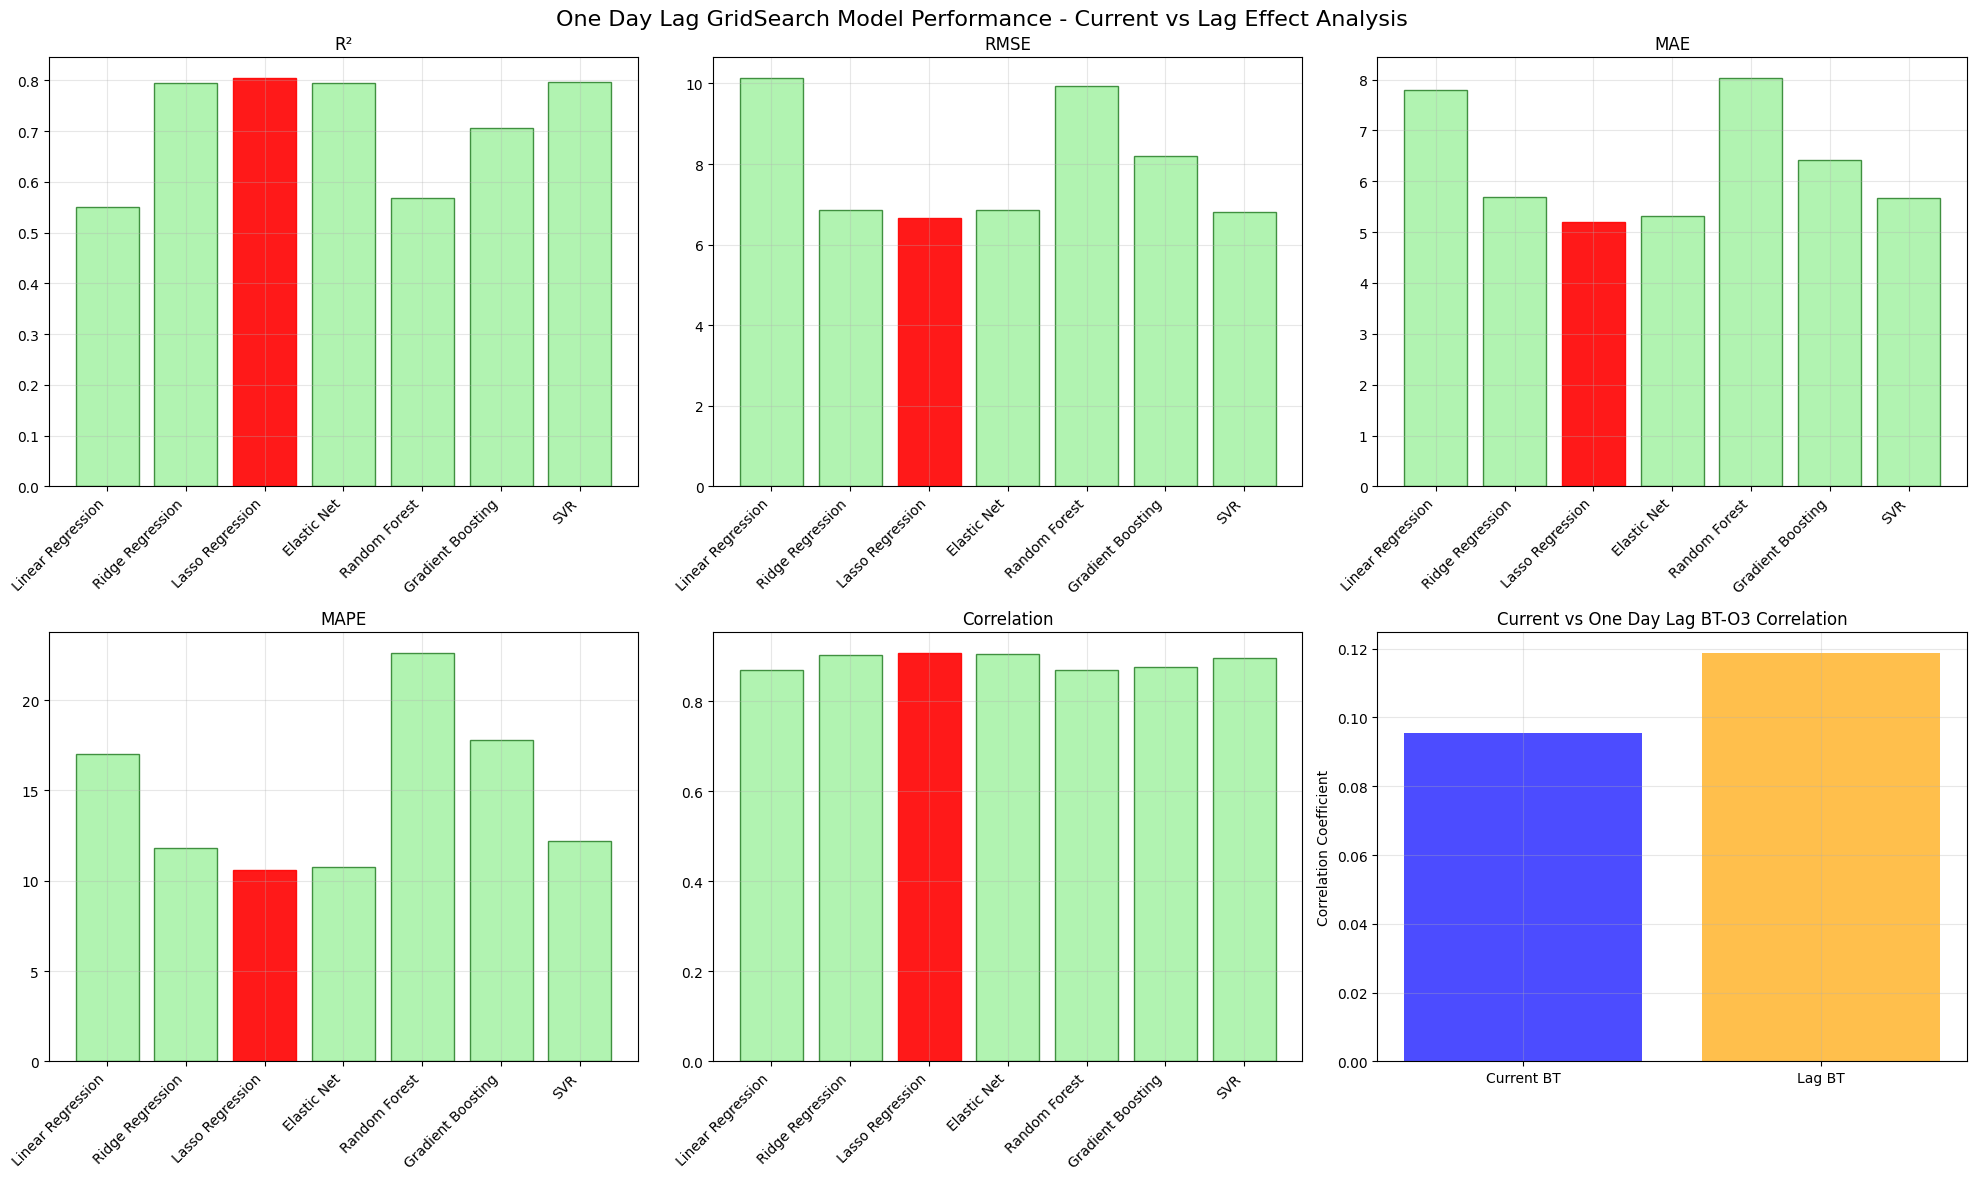


🌟 Random Forest Feature Importance Categories:
Current day BT features:
                 feature  importance
36  BT_month_interaction    0.024285
4               BT_ratio    0.005456
39             BT_change    0.003559
40       BT_change_ratio    0.003416
2             BT_squared    0.003060
One day lag BT features:
                      feature  importance
38  BT_lag1_month_interaction    0.034854
9               BT_ratio_lag1    0.005197
5                     BT_lag1    0.003292
6          BT_normalized_lag1    0.002662
7             BT_squared_lag1    0.002169
Other important features:
                  feature  importance
46  NO2(mg/kg)_normalized    0.288306
45  SO2(mg/kg)_normalized    0.141928
41                O3_lag1    0.085768
34               cos_year    0.082447
27              DayOfYear    0.059759
Current day BT features total importance: 0.0485
Lag BT features total importance: 0.0505
Other features total importance: 0.9010

🌟 Gradient Boosting Feature Importance Cate

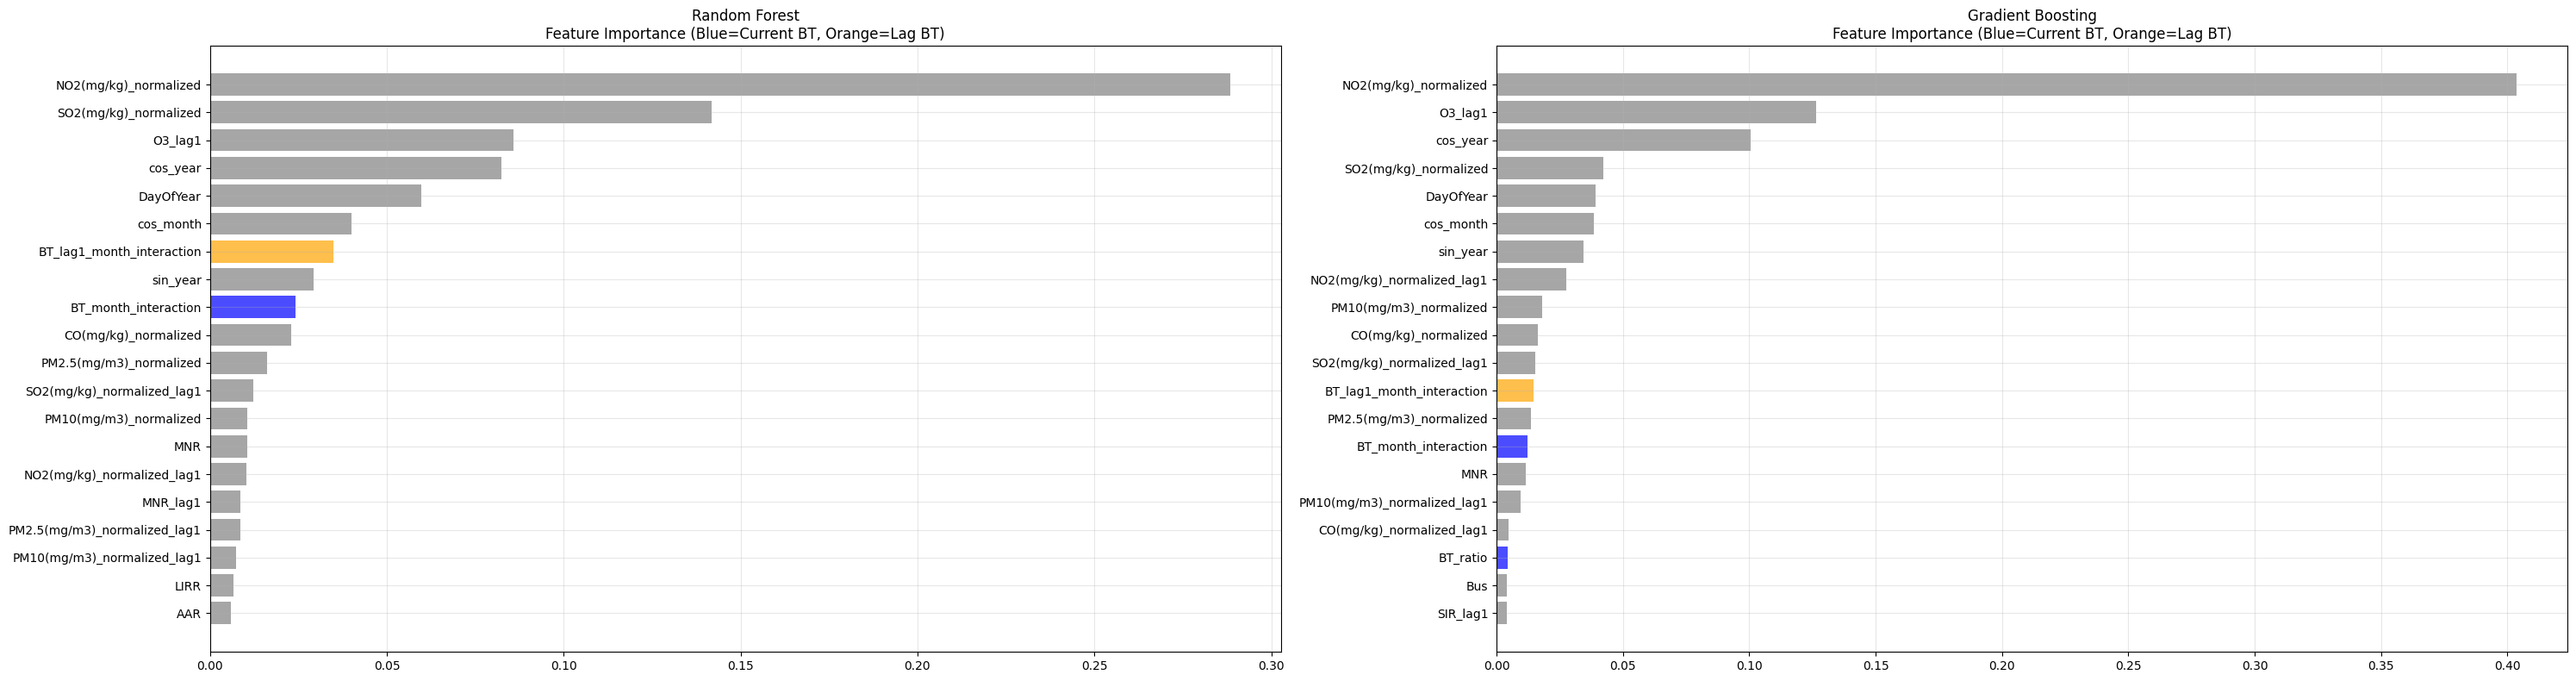

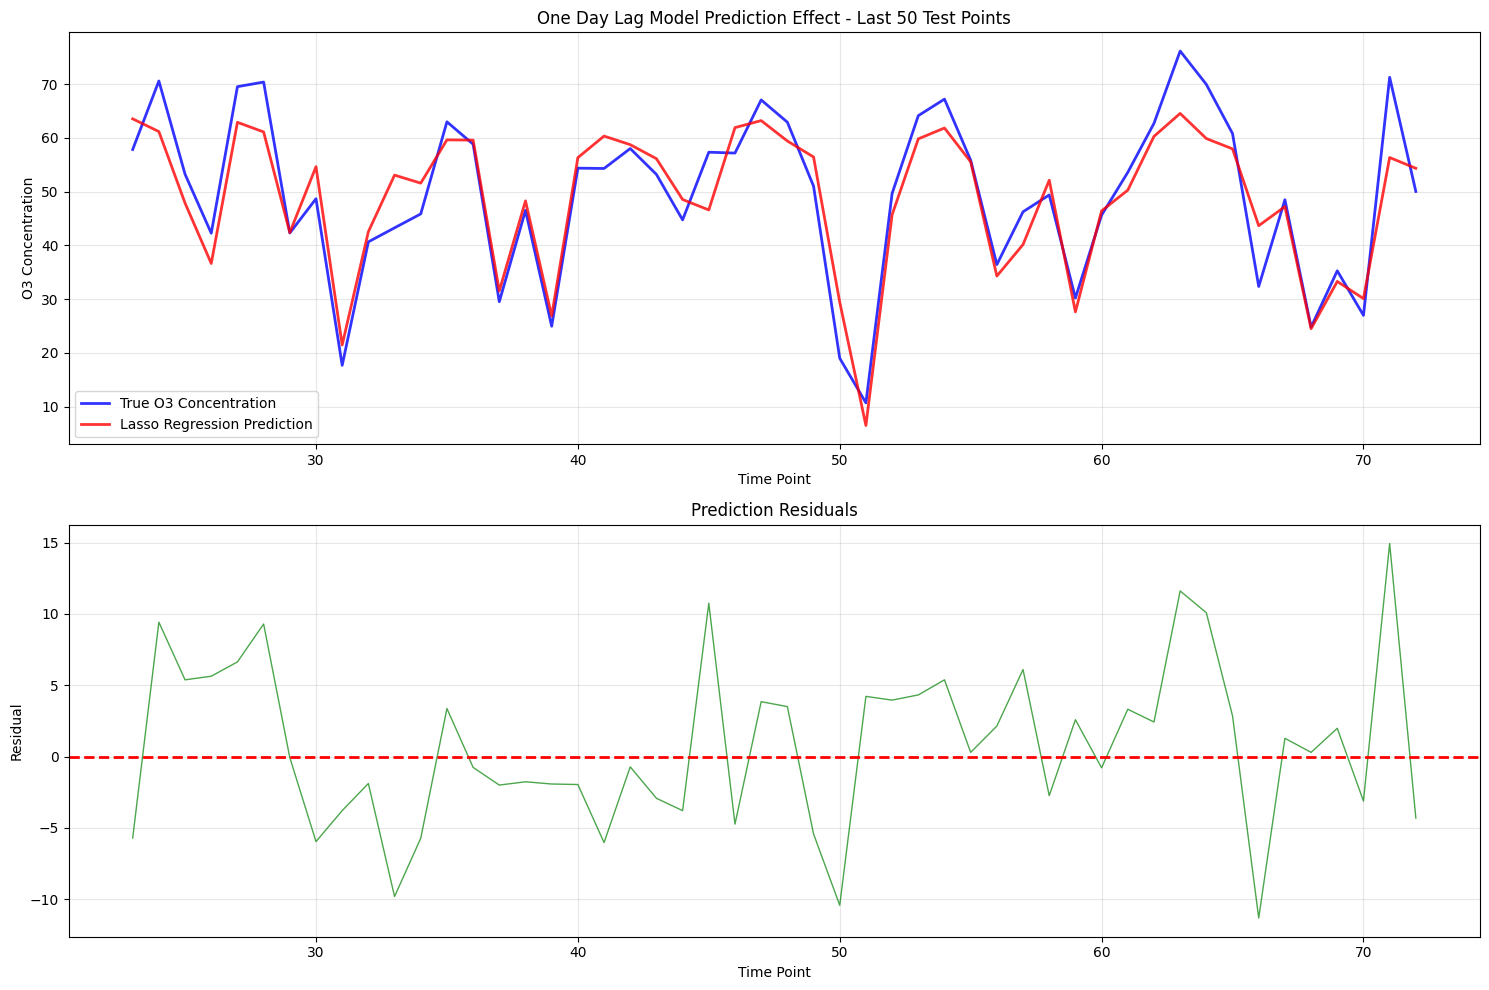


 One Day Lag GridSearch BT-O3 Relationship Analysis Summary
 5 Main Evaluation Metrics (Best Model):
1. MSE: 44.4983
2. RMSE: 6.6707
3. MAE: 5.1959
4. R²: 0.8053
5. MAPE: 10.62%

 Best Model: Lasso Regression
 Best R² Score: 0.8053
 Prediction Correlation: 0.9081
 Current Day BT-O3 Correlation: 0.2482
 One Day Lag BT-O3 Correlation: 0.1866

 Lag Effect Analysis:
   Current day BT has stronger correlation with O3, showing weak lag effect

 Conclusion:
   BT ridership (including lag) has strong predictive power for O3 concentration


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# Part 1: Data Loading and Preprocessing (One Day Lag)
# ============================================================================

def load_and_prepare_data_one_lag():
    """
    Data loading and preprocessing - Only includes one-day lag features
    """
    print("=== Data Loading and Preprocessing (BT vs O3 One Day Lag Analysis) ===")
    
    # 1. Read data
    traffic_df = pd.read_csv('MTA_Ridership_wide_format.csv')
    air_df = pd.read_csv('nyc_2024_air.csv')
    
    # 2. Data preprocessing
    traffic_df['Date'] = pd.to_datetime(traffic_df['Date'])
    air_df['DATE'] = pd.to_datetime(air_df['DATE'])
    
    # 3. Merge data
    merged_df = pd.merge(traffic_df, air_df, left_on='Date', right_on='DATE')
    
    # 4. Create time features
    merged_df['is_weekend'] = merged_df['Date'].dt.weekday >= 5
    merged_df['Month'] = merged_df['Date'].dt.month
    merged_df['DayOfWeek'] = merged_df['Date'].dt.dayofweek
    merged_df['DayOfYear'] = merged_df['Date'].dt.dayofyear
    
    # 5. Create seasonal features
    merged_df['sin_month'] = np.sin(2 * np.pi * merged_df['Month'] / 12)
    merged_df['cos_month'] = np.cos(2 * np.pi * merged_df['Month'] / 12)
    merged_df['sin_day'] = np.sin(2 * np.pi * merged_df['DayOfWeek'] / 7)
    merged_df['cos_day'] = np.cos(2 * np.pi * merged_df['DayOfWeek'] / 7)
    merged_df['sin_year'] = np.sin(2 * np.pi * merged_df['DayOfYear'] / 365)
    merged_df['cos_year'] = np.cos(2 * np.pi * merged_df['DayOfYear'] / 365)
    
    # 6. Create current day BT features
    merged_df['BT_normalized'] = (merged_df['BT'] - merged_df['BT'].mean()) / merged_df['BT'].std()
    merged_df['BT_squared'] = merged_df['BT'] ** 2
    merged_df['BT_log'] = np.log(merged_df['BT'] + 1)
    
    # 7. Create one-day lag features (key modification)
    merged_df['BT_lag1'] = merged_df['BT'].shift(1)
    merged_df['BT_normalized_lag1'] = merged_df['BT_normalized'].shift(1)
    merged_df['BT_squared_lag1'] = merged_df['BT_squared'].shift(1)
    merged_df['BT_log_lag1'] = merged_df['BT_log'].shift(1)
    
    # 8. Create one-day lag features for other transportation modes
    for transport in ['Subway', 'Bus', 'LIRR', 'MNR', 'SIR', 'AAR']:
        merged_df[f'{transport}_lag1'] = merged_df[transport].shift(1)
    
    # 9. Create one-day lag O3 features (for prediction)
    merged_df['O3_lag1'] = merged_df['O3(mg/kg)'].shift(1)
    
    # 10. Create one-day lag features for other air quality parameters
    for param in ['PM2.5(mg/m3)', 'PM10(mg/m3)', 'CO(mg/kg)', 'SO2(mg/kg)', 'NO2(mg/kg)']:
        if param in merged_df.columns:
            merged_df[f'{param}_lag1'] = merged_df[param].shift(1)
            merged_df[f'{param}_normalized'] = (merged_df[param] - merged_df[param].mean()) / merged_df[param].std()
            merged_df[f'{param}_normalized_lag1'] = merged_df[f'{param}_normalized'].shift(1)
    
    # 11. Create current and one-day lag total traffic features
    merged_df['Total_Traffic'] = merged_df[['AAR', 'BT', 'Bus', 'LIRR', 'MNR', 'SIR', 'Subway']].sum(axis=1)
    merged_df['Total_Traffic_lag1'] = merged_df['Total_Traffic'].shift(1)
    merged_df['BT_ratio'] = merged_df['BT'] / merged_df['Total_Traffic']
    merged_df['BT_ratio_lag1'] = merged_df['BT_lag1'] / merged_df['Total_Traffic_lag1']
    
    # 12. Create current and lag interaction features
    merged_df['BT_weekend_interaction'] = merged_df['BT'] * merged_df['is_weekend']
    merged_df['BT_month_interaction'] = merged_df['BT'] * merged_df['Month']
    merged_df['BT_lag1_weekend_interaction'] = merged_df['BT_lag1'] * merged_df['is_weekend']
    merged_df['BT_lag1_month_interaction'] = merged_df['BT_lag1'] * merged_df['Month']
    
    # 13. Create current vs lag difference features
    merged_df['BT_change'] = merged_df['BT'] - merged_df['BT_lag1']
    merged_df['BT_change_ratio'] = merged_df['BT_change'] / (merged_df['BT_lag1'] + 1)  # avoid division by zero
    
    # 14. Create previous day weekend feature
    merged_df['was_weekend_lag1'] = merged_df['is_weekend'].shift(1)
    
    print(f"Data shape: {merged_df.shape}")
    print(f"Date range: {merged_df['Date'].min()} to {merged_df['Date'].max()}")
    print(f"BT ridership range: {merged_df['BT'].min():.0f} - {merged_df['BT'].max():.0f}")
    print(f"O3 concentration range: {merged_df['O3(mg/kg)'].min():.3f} - {merged_df['O3(mg/kg)'].max():.3f}")
    
    return merged_df

# ============================================================================
# Part 2: Feature Selection (Current Day + One Day Lag)
# ============================================================================

def prepare_bt_o3_features_one_lag(df):
    """
    Prepare BT and O3 features (Current Day + One Day Lag)
    """
    print(f"\n=== BT-O3 Feature Preparation (Current Day + One Day Lag) ===")
    
    # Define feature set - Current day features + One day lag features
    feature_columns = [
        # Current day BT features
        'BT',
        'BT_normalized',
        'BT_squared',
        'BT_log',
        'BT_ratio',
        
        # One day lag BT features
        'BT_lag1',
        'BT_normalized_lag1',
        'BT_squared_lag1',
        'BT_log_lag1',
        'BT_ratio_lag1',
        
        # Current day other transportation modes
        'Subway', 'Bus', 'LIRR', 'MNR', 'SIR', 'AAR',
        'Total_Traffic',
        
        # One day lag other transportation modes
        'Subway_lag1', 'Bus_lag1', 'LIRR_lag1', 'MNR_lag1', 'SIR_lag1', 'AAR_lag1',
        'Total_Traffic_lag1',
        
        # Time features
        'is_weekend', 'Month', 'DayOfWeek', 'DayOfYear',
        'was_weekend_lag1',
        
        # Seasonal features
        'sin_month', 'cos_month', 'sin_day', 'cos_day',
        'sin_year', 'cos_year',
        
        # Current day interaction features
        'BT_weekend_interaction', 'BT_month_interaction',
        
        # One day lag interaction features
        'BT_lag1_weekend_interaction', 'BT_lag1_month_interaction',
        
        # Change features
        'BT_change', 'BT_change_ratio',
        
        # One day lag O3 features
        'O3_lag1',
        
        # Current day other air quality parameters
        'PM2.5(mg/m3)_normalized', 'PM10(mg/m3)_normalized', 
        'CO(mg/kg)_normalized', 'SO2(mg/kg)_normalized', 'NO2(mg/kg)_normalized',
        
        # One day lag other air quality parameters
        'PM2.5(mg/m3)_normalized_lag1', 'PM10(mg/m3)_normalized_lag1',
        'CO(mg/kg)_normalized_lag1', 'SO2(mg/kg)_normalized_lag1', 'NO2(mg/kg)_normalized_lag1'
    ]
    
    target = 'O3(mg/kg)'
    
    # Check feature availability
    available_features = [col for col in feature_columns if col in df.columns]
    missing_features = [col for col in feature_columns if col not in df.columns]
    
    if missing_features:
        print(f"Missing features: {missing_features}")
    
    print(f"Available features count: {len(available_features)}")
    print(f"Current day BT features: {[f for f in available_features if 'BT' in f and 'lag' not in f]}")
    print(f"One day lag BT features: {[f for f in available_features if 'BT' in f and 'lag1' in f]}")
    
    # Prepare modeling data (remove rows with NaN, mainly first row due to lag)
    model_data = df[available_features + [target]].dropna()
    
    X = model_data[available_features]
    y = model_data[target]
    
    # Basic statistics
    print(f"Modeling data shape: {model_data.shape}")
    print(f"Current day BT-O3 correlation: {model_data['BT'].corr(model_data[target]):.3f}")
    print(f"One day lag BT-O3 correlation: {model_data['BT_lag1'].corr(model_data[target]):.3f}")
    
    return X, y, available_features

# ============================================================================
# Part 3: Comprehensive Evaluation Metrics
# ============================================================================

def calculate_comprehensive_metrics(y_true, y_pred):
    """
    Calculate comprehensive evaluation metrics
    """
    # 5 main metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate MAPE, avoid division by zero
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.inf
    
    # Additional metrics
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    median_ae = median_absolute_error(y_true, y_pred)
    explained_var = explained_variance_score(y_true, y_pred)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape,
        'Correlation': correlation,
        'MedianAE': median_ae,
        'ExplainedVar': explained_var
    }

# ============================================================================
# Part 4: GridSearch Model Configuration
# ============================================================================

def create_gridsearch_models():
    """
    Create GridSearch configuration for all models
    """
    models_config = {
        'Linear Regression': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())
            ]),
            'params': {
                'regressor__fit_intercept': [True, False]
            }
        },
        
        'Ridge Regression': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', Ridge(random_state=42))
            ]),
            'params': {
                'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
                'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr']
            }
        },
        
        'Lasso Regression': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', Lasso(random_state=42, max_iter=3000))
            ]),
            'params': {
                'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
                'regressor__selection': ['cyclic', 'random']
            }
        },
        
        'Elastic Net': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', ElasticNet(random_state=42, max_iter=3000))
            ]),
            'params': {
                'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
                'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                'regressor__selection': ['cyclic', 'random']
            }
        },
        
        'Random Forest': {
            'pipeline': Pipeline([
                ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
            ]),
            'params': {
                'regressor__n_estimators': [50, 100, 200, 300],
                'regressor__max_depth': [5, 10, 15, 20, None],
                'regressor__min_samples_split': [2, 5, 10, 20],
                'regressor__min_samples_leaf': [1, 2, 4, 8],
                'regressor__max_features': ['sqrt', 'log2', None, 0.5]
            }
        },
        
        'Gradient Boosting': {
            'pipeline': Pipeline([
                ('regressor', GradientBoostingRegressor(random_state=42))
            ]),
            'params': {
                'regressor__n_estimators': [50, 100, 200, 300],
                'regressor__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                'regressor__max_depth': [3, 5, 7, 9, 12],
                'regressor__subsample': [0.7, 0.8, 0.9, 1.0],
                'regressor__max_features': ['sqrt', 'log2', None]
            }
        },
        
        'SVR': {
            'pipeline': Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', SVR())
            ]),
            'params': {
                'regressor__C': [0.01, 0.1, 1, 10, 100, 1000],
                'regressor__kernel': ['rbf', 'linear', 'poly'],
                'regressor__gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1],
                'regressor__epsilon': [0.001, 0.01, 0.1, 0.2, 0.5]
            }
        }
    }
    
    return models_config

# ============================================================================
# Part 5: GridSearch Training
# ============================================================================

def train_models_with_gridsearch(X, y, models_config, test_size=0.2, cv_folds=5):
    """
    Train all models using GridSearch
    """
    print(f"\n=== Training All Models with GridSearch (One Day Lag Version) ===")
    
    # Time series split
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Training period current day BT-O3 correlation: {X_train['BT'].corr(y_train):.3f}")
    print(f"Training period lag BT-O3 correlation: {X_train['BT_lag1'].corr(y_train):.3f}")
    print(f"Test period current day BT-O3 correlation: {X_test['BT'].corr(y_test):.3f}")
    print(f"Test period lag BT-O3 correlation: {X_test['BT_lag1'].corr(y_test):.3f}")
    
    # Time series cross validation
    tscv = TimeSeriesSplit(n_splits=cv_folds)
    
    results = []
    best_models = {}
    predictions = {}
    
    for model_name, config in models_config.items():
        print(f"\n GridSearch training {model_name}...")
        
        try:
            # Create GridSearchCV
            grid_search = GridSearchCV(
                estimator=config['pipeline'],
                param_grid=config['params'],
                cv=tscv,
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                verbose=0,
                return_train_score=True
            )
            
            # Training
            grid_search.fit(X_train, y_train)
            
            # Get best model
            best_model = grid_search.best_estimator_
            
            # Predictions
            y_pred_train = best_model.predict(X_train)
            y_pred_test = best_model.predict(X_test)
            
            # Calculate metrics
            train_metrics = calculate_comprehensive_metrics(y_train, y_pred_train)
            test_metrics = calculate_comprehensive_metrics(y_test, y_pred_test)
            
            # Store results
            result = {
                'Model': model_name,
                'Best_Params': grid_search.best_params_,
                'CV_Score': -grid_search.best_score_,
                'Train_MSE': train_metrics['MSE'],
                'Train_RMSE': train_metrics['RMSE'],
                'Train_MAE': train_metrics['MAE'],
                'Train_R²': train_metrics['R²'],
                'Train_MAPE': train_metrics['MAPE'],
                'Test_MSE': test_metrics['MSE'],
                'Test_RMSE': test_metrics['RMSE'],
                'Test_MAE': test_metrics['MAE'],
                'Test_R²': test_metrics['R²'],
                'Test_MAPE': test_metrics['MAPE'],
                'Test_Correlation': test_metrics['Correlation'],
                'Test_MedianAE': test_metrics['MedianAE'],
                'Test_ExplainedVar': test_metrics['ExplainedVar']
            }
            
            results.append(result)
            best_models[model_name] = best_model
            predictions[model_name] = y_pred_test
            
            print(f" Complete")
            print(f"   Best parameters: {grid_search.best_params_}")
            print(f"   CV RMSE: {-grid_search.best_score_:.4f}")
            print(f"   Test R²: {test_metrics['R²']:.4f}")
            print(f"   Test correlation: {test_metrics['Correlation']:.4f}")
            
        except Exception as e:
            print(f" Failed - {str(e)}")
            continue
    
    return results, best_models, predictions, y_test, X_test

# ============================================================================
# Part 6: Results Analysis (Enhanced Version, Focus on Lag Effects)
# ============================================================================

def analyze_one_lag_results(results, predictions, y_test, X_test, feature_names, best_models):
    """
    Analyze GridSearch results with one day lag
    """
    print(f"\n=== One Day Lag GridSearch Results Analysis ===")
    
    results_df = pd.DataFrame(results)
    
    # 1. Detailed performance table
    print("\n📊 Complete Model Performance Comparison:")
    display_cols = ['Model', 'CV_Score', 'Test_R²', 'Test_RMSE', 'Test_MAE', 'Test_MAPE', 'Test_Correlation']
    print(results_df[display_cols].round(4))
    
    # 2. Current vs lag feature importance analysis
    print("\n🔍 Current vs One Day Lag BT Feature Analysis:")
    current_bt_corr = X_test['BT'].corr(y_test)
    lag_bt_corr = X_test['BT_lag1'].corr(y_test)
    print(f"Current day BT-O3 correlation: {current_bt_corr:.4f}")
    print(f"One day lag BT-O3 correlation: {lag_bt_corr:.4f}")
    print(f"Lag effect strength: {'Strong' if abs(lag_bt_corr) > abs(current_bt_corr) else 'Weak'}")
    
    # 3. Visualize current vs lag effects
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('One Day Lag GridSearch Model Performance - Current vs Lag Effect Analysis', fontsize=16)
    
    # 3.1 Main performance metrics
    main_metrics = ['Test_R²', 'Test_RMSE', 'Test_MAE', 'Test_MAPE', 'Test_Correlation']
    positions = [(0,0), (0,1), (0,2), (1,0), (1,1)]
    
    for i, metric in enumerate(main_metrics):
        row, col = positions[i]
        bars = axes[row, col].bar(results_df['Model'], results_df[metric], 
                                  color='lightgreen', edgecolor='darkgreen', alpha=0.7)
        axes[row, col].set_title(f'{metric.replace("Test_", "")}')
        axes[row, col].set_xticklabels(results_df['Model'], rotation=45, ha='right')
        axes[row, col].grid(True, alpha=0.3)
        
        # Highlight best model
        if metric in ['Test_R²', 'Test_Correlation']:
            best_idx = results_df[metric].idxmax()
        else:
            best_idx = results_df[metric].idxmin()
        bars[best_idx].set_color('red')
        bars[best_idx].set_alpha(0.9)
    
    # 3.2 Current vs lag BT correlation comparison
    axes[1, 2].bar(['Current BT', 'Lag BT'], [current_bt_corr, lag_bt_corr], 
                   color=['blue', 'orange'], alpha=0.7)
    axes[1, 2].set_title('Current vs One Day Lag BT-O3 Correlation')
    axes[1, 2].set_ylabel('Correlation Coefficient')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 4. Feature importance analysis (focus on current vs lag)
    tree_models = ['Random Forest', 'Gradient Boosting']
    available_tree_models = [m for m in tree_models if m in best_models]
    
    if available_tree_models:
        fig, axes = plt.subplots(1, len(available_tree_models), figsize=(15*len(available_tree_models), 8))
        
        if len(available_tree_models) == 1:
            axes = [axes]
        
        for i, model_name in enumerate(available_tree_models):
            model = best_models[model_name]
            
            if hasattr(model.named_steps['regressor'], 'feature_importances_'):
                importance = model.named_steps['regressor'].feature_importances_
                
                importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importance
                }).sort_values('importance', ascending=False)
                
                # Categorize features
                current_bt_features = importance_df[importance_df['feature'].str.contains('BT') & ~importance_df['feature'].str.contains('lag')]
                lag_bt_features = importance_df[importance_df['feature'].str.contains('BT') & importance_df['feature'].str.contains('lag')]
                other_features = importance_df[~importance_df['feature'].str.contains('BT')]
                
                print(f"\n🌟 {model_name} Feature Importance Categories:")
                print("Current day BT features:")
                print(current_bt_features.head())
                print("One day lag BT features:")
                print(lag_bt_features.head())
                print("Other important features:")
                print(other_features.head())
                
                # Calculate total importance by feature type
                current_bt_total = current_bt_features['importance'].sum()
                lag_bt_total = lag_bt_features['importance'].sum()
                other_total = other_features['importance'].sum()
                
                print(f"Current day BT features total importance: {current_bt_total:.4f}")
                print(f"Lag BT features total importance: {lag_bt_total:.4f}")
                print(f"Other features total importance: {other_total:.4f}")
                
                # Visualize top 20 features
                top_features = importance_df.head(20)
                colors = []
                for feat in top_features['feature']:
                    if 'BT' in feat and 'lag' not in feat:
                        colors.append('blue')  # Current day BT
                    elif 'BT' in feat and 'lag' in feat:
                        colors.append('orange')  # Lag BT
                    else:
                        colors.append('gray')  # Others
                
                axes[i].barh(top_features['feature'], top_features['importance'], color=colors, alpha=0.7)
                axes[i].set_title(f'{model_name}\nFeature Importance (Blue=Current BT, Orange=Lag BT)')
                axes[i].invert_yaxis()
                axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # 5. Time series prediction effect (show lag model prediction capability)
    plt.figure(figsize=(15, 10))
    
    best_model_name = results_df.loc[results_df['Test_R²'].idxmax(), 'Model']
    best_predictions = predictions[best_model_name]
    
    # Show last 50 test points
    display_points = min(50, len(y_test))
    test_indices = range(len(y_test) - display_points, len(y_test))
    
    plt.subplot(2, 1, 1)
    plt.plot(test_indices, y_test.iloc[-display_points:].values, 
             label='True O3 Concentration', color='blue', alpha=0.8, linewidth=2)
    plt.plot(test_indices, best_predictions[-display_points:], 
             label=f'{best_model_name} Prediction', color='red', alpha=0.8, linewidth=2)
    plt.title(f'One Day Lag Model Prediction Effect - Last {display_points} Test Points')
    plt.xlabel('Time Point')
    plt.ylabel('O3 Concentration')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    residuals = y_test.iloc[-display_points:].values - best_predictions[-display_points:]
    plt.plot(test_indices, residuals, color='green', alpha=0.7, linewidth=1)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
    plt.title('Prediction Residuals')
    plt.xlabel('Time Point')
    plt.ylabel('Residual')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# ============================================================================
# Part 7: Main Execution Function
# ============================================================================

def main():
    """
    Main execution function - GridSearch all models, one day lag analysis
    """
    print(" Starting BT-O3 Relationship GridSearch Analysis (One Day Lag Version)")
    print("="*60)
    
    try:
        # 1. Data preparation
        df = load_and_prepare_data_one_lag()
        
        # 2. Feature engineering (one day lag)
        X, y, feature_names = prepare_bt_o3_features_one_lag(df)
        
        # 3. GridSearch model configuration
        models_config = create_gridsearch_models()
        
        # 4. GridSearch training
        results, best_models, predictions, y_test, X_test = train_models_with_gridsearch(
            X, y, models_config, test_size=0.2, cv_folds=5
        )
        
        # 5. Results analysis (focus on lag effects)
        results_df = analyze_one_lag_results(
            results, predictions, y_test, X_test, feature_names, best_models
        )
        
        # 6. Final summary
        print("\n" + "="*60)
        print(" One Day Lag GridSearch BT-O3 Relationship Analysis Summary")
        print("="*60)
        
        best_model_name = results_df.loc[results_df['Test_R²'].idxmax(), 'Model']
        best_r2 = results_df['Test_R²'].max()
        best_corr = results_df.loc[results_df['Test_R²'].idxmax(), 'Test_Correlation']
        
        print(" 5 Main Evaluation Metrics (Best Model):")
        best_row = results_df.loc[results_df['Test_R²'].idxmax()]
        print(f"1. MSE: {best_row['Test_MSE']:.4f}")
        print(f"2. RMSE: {best_row['Test_RMSE']:.4f}")
        print(f"3. MAE: {best_row['Test_MAE']:.4f}")
        print(f"4. R²: {best_row['Test_R²']:.4f}")
        print(f"5. MAPE: {best_row['Test_MAPE']:.2f}%")
        
        print(f"\n Best Model: {best_model_name}")
        print(f" Best R² Score: {best_r2:.4f}")
        print(f" Prediction Correlation: {best_corr:.4f}")
        print(f" Current Day BT-O3 Correlation: {X['BT'].corr(y):.4f}")
        print(f" One Day Lag BT-O3 Correlation: {X['BT_lag1'].corr(y):.4f}")
        
        # Lag effect analysis
        lag_stronger = abs(X['BT_lag1'].corr(y)) > abs(X['BT'].corr(y))
        print(f"\n Lag Effect Analysis:")
        if lag_stronger:
            print("   One day lag BT has stronger correlation with O3 than current day BT, showing significant lag effect")
        else:
            print("   Current day BT has stronger correlation with O3, showing weak lag effect")
        
        print("\n Conclusion:")
        if best_r2 > 0.3:
            print("   BT ridership (including lag) has strong predictive power for O3 concentration")
        elif best_r2 > 0.1:
            print("   BT ridership (including lag) has moderate predictive power for O3 concentration")
        else:
            print("   BT ridership (including lag) has limited predictive power for O3 concentration")
        
        return results_df, best_models, predictions
        
    except Exception as e:
        print(f" Analysis process error: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None

# ============================================================================
# Execute Analysis
# ============================================================================

if __name__ == "__main__":
    results_df, best_models, predictions = main()
